# Exploratory analysis of petTOAD dataframe (CN and MCI patients)

<div class="alert alert-block alert-info">
<b>Remember:</b> For this analysis you need to activate the `analysis` conda environment
</div>

This notebooks serves as a first exploratory analysis of white matter hyperintensities (WMH) volumes in cognitively normal (CN) subjects and patients with mild cognitive impairment (MCI). Data were taken from the Alzheimer's Disease Neuroinitiative (ADNI) database and then preprocessed with fmriprep/xcp_d. Furthermore WMH were calculated with deepNeuroSeg and visually checked and modified, as necessary. In particular, we have WMH volume data obtained in subject space and transformed from subject space to MNI2009in6cAsym space. Subjects are binned into WMH/no WMH respectively if the have a summed up Fazekas score (periventricular + deep) <=2 ("noWMH") or >2 ("WMH"). 


In [1]:
# Imports and directories
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from pathlib import Path

SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
UTL_DIR = DATA_DIR / "utils"
RES_DIR = SPINE / "results"

#Read in data
pts_df = pd.read_csv(RES_DIR / "petTOAD_dataframe.csv", index_col = [0])

# Current implementation to say that a patient has WMH is based on the threshold of the subj space WMH volume
pts_df['WMH'] = np.where(pts_df["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH")

Let's first calculate some general summary statistics regarding sex, age and diagnosis.

In [2]:
n_pts = len(pts_df)
age_min = round(pts_df['Age'].describe().loc['min'], 0)
age_max = round(pts_df['Age'].describe().loc['max'],0)
females_num = pts_df.groupby('Sex').count().loc['F'].loc['Group']
males_num = pts_df.groupby('Sex').count().loc['F'].loc['Group']
cu_num = pts_df.groupby('Group_bin').count().loc['CN'].loc['Group']
mci_num = pts_df.groupby('Group_bin').count().loc['MCI'].loc['Group']
cu_no_wmh = len(pts_df[pts_df['Group_bin_Fazekas'] == 'CN_no_WMH'])
cu_wmh = len(pts_df[pts_df['Group_bin_Fazekas'] == 'CN_WMH'])
mci_no_wmh = len(pts_df[pts_df['Group_bin_Fazekas'] == 'MCI_no_WMH'])
mci_wmh = len(pts_df[pts_df['Group_bin_Fazekas'] == 'MCI_WMH'])

print(f"""After exclusion, {n_pts} patients (age-range: {age_min}-{age_max}, {females_num} ({round(females_num / n_pts * 100, 2)}%) females, {males_num} ({round(males_num / n_pts * 100, 2)}%) males, 
      {cu_num} ({round(cu_num / n_pts* 100, 1)}%) CU and {mci_num} ({round(mci_num / n_pts * 100, 1)}%) MCI) were considered for the modeling pipeline.""")
print(f"""Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2. Accordingly, there were: 
      {cu_no_wmh} ({round(cu_no_wmh / cu_num * 100, 1)}%) CU without WMH, {cu_wmh} ({round(cu_wmh / cu_num * 100, 1)}%) CU with WMH, {mci_no_wmh} ({round(mci_no_wmh / mci_num * 100, 1)}%) MCI without WMH, {mci_wmh} ({round(mci_wmh / mci_num* 100, 1)}%) MCI with WMH.""")

After exclusion, 267 patients (age-range: 56.0-90.0, 156 (58.43%) females, 156 (58.43%) males, 
      154 (57.7%) CU and 113 (42.3%) MCI) were considered for the modeling pipeline.
Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2. Accordingly, there were: 
      82 (53.2%) CU without WMH, 72 (46.8%) CU with WMH, 55 (48.7%) MCI without WMH, 58 (51.3%) MCI with WMH.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCI v.s. CN: t-test independent samples with Bonferroni correction, P_val=3.042e-04 stat=3.660e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCI v.s. CN: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.672e-01 U_stat=9.562e+03


Text(1275.086352657005, 0.5, 'WMH load (mm^3)')

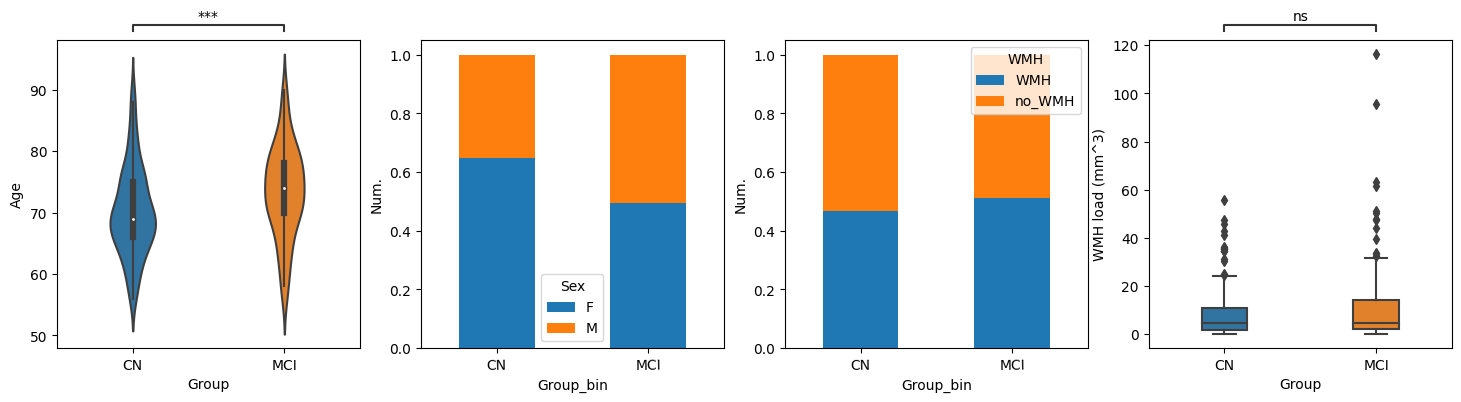

In [3]:
# Create contingency tables with percentages for plotting
ct_sex = pd.crosstab(pts_df['Sex'], pts_df['Group_bin'], normalize = "columns")
# Create contingency tables with percentages for plotting
ct_wmh = pd.crosstab(pts_df['WMH'], pts_df['Group_bin'], normalize = "columns")
# Create overall figure
plt.figure(figsize = (18,4))
# Set first graph

axs1 = plt.subplot(1, 4, 1)
order = ['CN', 'MCI']
vp = sns.violinplot(pts_df, x = "Group_bin", y = "Age", order = order, width = 0.3, ax = axs1)
stats = add_stat_annotation(vp, data=pts_df, x="Group_bin", y="Age",
                    box_pairs=[("CN", "MCI")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=3);
axs1.set_xlabel("Group")
# Set second graph
axs2 = plt.subplot(1, 4, 2)
ct_sex.T.plot(kind = "bar", stacked = True, rot = 1, ylabel = "Num.", ax = axs2)
axs1.set_xlabel("Group")

# Set third graph
axs2 = plt.subplot(1, 4, 3)
ct_wmh.T.plot(kind = "bar", stacked = True, rot = 1, ylabel = "Num.", ax = axs2)
axs1.set_xlabel("Group")


# Set fourth graph
axs4 = plt.subplot(1, 4, 4)
order = ['CN', 'MCI']
wmh_mm = pts_df['WMH_load_subj_space'] / 1000
vp = sns.boxplot(pts_df, x = "Group_bin", y = wmh_mm, order = order, width = 0.3, ax = axs4)
stats = add_stat_annotation(vp, data=pts_df, x="Group_bin", y="WMH_load_subj_space",
                    box_pairs=[("CN", "MCI")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=3);
axs4.set_xlabel("Group")
axs4.set_ylabel("WMH load (mm^3)")

In [4]:
# Get age summary stats
age_summ = pts_df.groupby(["Group_bin"])['Age'].describe()
print(f"Median age for CN subjects = {age_summ['50%']['CN']} (IQR = {age_summ['25%']['CN']} - {age_summ['75%']['CN']})")
print(f"Median age for MCI subjects = {age_summ['50%']['MCI']} (IQR = {age_summ['25%']['MCI']} - {age_summ['75%']['MCI']})")
# Create contingency table for chi-squared
ct_sex = pd.crosstab(pts_df['Sex'], pts_df['Group_bin'])
c1, p1, dof1, expected1 = ss.chi2_contingency(ct_sex)
if p1 < 0.05:
    print(f"MCI and CU showed statistically significant sex differences, p = {round(p1, 3)}")
else:
    print(f"MCI and CU showed no sex groups differences, p = {round(p1,3)}")

# Create contingency table for chi-squared
ct_wmh = pd.crosstab(pts_df['WMH'], pts_df['Group_bin'])
c2, p2, dof2, expected2 = ss.chi2_contingency(ct_wmh)
if p2 < 0.05:
    print(f"MCI and CU showed statistically significant differences in wmh prevalence, p = {round(p2,3)}")
else:
    print(f"MCI and CU showed no significant differences in wmh prevalence, p = {round(p2, 3)}")


Median age for CN subjects = 69.0 (IQR = 66.0 - 75.0)
Median age for MCI subjects = 74.0 (IQR = 70.0 - 78.0)
MCI and CU showed statistically significant sex differences, p = 0.017
MCI and CU showed no significant differences in wmh prevalence, p = 0.539


In the CN group there are significantly more women than men. There are no statistically significant differences regarding WMH load. MCI patients are significantly older than CN. 

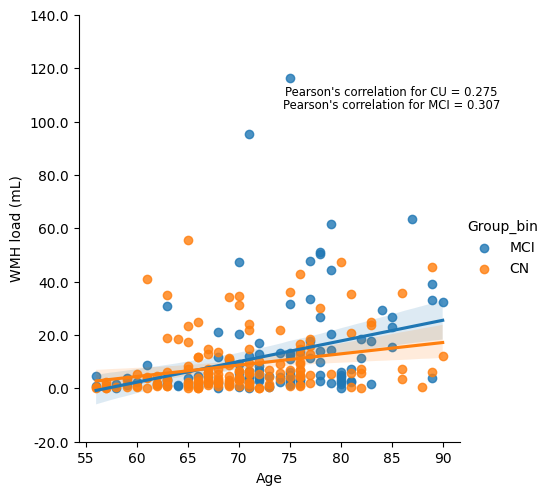

In [8]:
sns.lmplot(pts_df, y = "WMH_load_subj_space", x = "Age", hue = "Group_bin")
cu = pts_df[pts_df["Group_bin"] == "CN"]
mci = pts_df[pts_df["Group_bin"] == "MCI"]
cu_pears = ss.pearsonr(cu['WMH_load_subj_space'], cu['Age'])
mci_pears = ss.pearsonr(mci['WMH_load_subj_space'], mci['Age'])
plt.text(85, 110000, f"Pearson's correlation for CU = {np.round(cu_pears.correlation, 3)}", horizontalalignment='center', size='small', color='black')
plt.text(85, 105000, f"Pearson's correlation for MCI = {np.round(mci_pears.correlation, 3)}", horizontalalignment='center', size='small', color='black')
plt.xlabel("Age")
# Convert from mm^3 to mL without changing underlying data...
locs, labels = plt.yticks()
labels = [item/1000 for item in locs]
plt.yticks(locs, labels)
plt.ylabel("WMH load (mL)");

Now, let's make a final summary table...

In [ ]:
# Make final table
ct_sex['p-value'] = p1
ct_wmh['p-value'] = p2

p_age = stats[1][0].__dict__['pval']
median_age = age_summ['50%'].astype(str) + " (" + age_summ['25%'].astype(str) + "-" + age_summ['75%'].astype(str) + ")"
age_summ["Median (IQR)"] = median_age
ct_age = age_summ.T.iloc[-1:,:]
ct_age['p-value'] = p_age
table = pd.concat([ct_sex, ct_wmh, ct_age])
table['p-value'] = round(table['p-value'], 4)
print(table)

Group_bin                   CN               MCI  p-value
F                          100                56   0.0167
M                           54                57   0.0167
WMH                         72                58   0.5386
no_WMH                      82                55   0.5386
Median (IQR)  69.0 (66.0-75.0)  74.0 (70.0-78.0)   0.1672


# Other potential analyses

<div class="alert alert-block alert-info">
<b>Note:</b> this works for those sujs for whom we have adnimerge data...
</div>
Let's repeat the same analyses as we did before...



In [ ]:
# adnimerge = pd.read_csv(RES_DIR / "ADNIMERGE_petTOAD.csv")
# adnimerge['WMH'] = np.where(adnimerge["Group_bin_subj"].str.contains("no_WMH"), "no_WMH", "WMH")
# # Create contingency tables
# ct_sex = pd.crosstab(adnimerge['Sex'], adnimerge['Group_bin'])
# c1, p1, dof1, expected1 = ss.chi2_contingency(ct_sex)

# # Get age summary stats
# age_summ = adnimerge.groupby(["Group_bin"])['Age'].describe()
# print(f"Median age for CN subjects = {age_summ['50%']['CN']} (IQR = {age_summ['25%']['CN']} - {age_summ['75%']['CN']})")
# print(f"Median age for MCI subjects = {age_summ['50%']['MCI']} (IQR = {age_summ['25%']['MCI']} - {age_summ['75%']['MCI']})")

# # Create contingency tables for wmh presence
# ct_wmh = pd.crosstab(adnimerge['WMH'], adnimerge['Group_bin'])
# c2, p2, dof2, expected2 = ss.chi2_contingency(ct_wmh)

# # Test if WMH volumes are normal or not 
# normality_subj = ss.normaltest(adnimerge["WMH_load_subj_space"])
# normality_mni = ss.normaltest(adnimerge["WMH_load_subj_space"])
# print("\n")
# # If normal use parametric tests, else use non-parametric
# if normality_subj[1] < 0.05:
#     print("Data is not normally distributed in subject space, you should use non-parametric tests\n")
# else:
#     print("Data is normally distributed in subject space, you should use parametric tests\n")

# if normality_mni[1] < 0.05:
#     print("Data is not normally distributed in MNI space, you should use non-parametric tests\n")
# else:
#     print("Data is normally distributed in MNI space, you should use parametric tests\n")

# order = ['CN', 'MCI']

# # Create overall figure
# fig, axs = plt.subplots(2, 3, figsize = (14,8))
# # Set first graph
# ct_sex.T.plot(kind = "bar", stacked = True, rot = 1, ylabel = "Num.", ax = axs[0,0])
# axs[0,0].set_xlabel("Group")
# axs[0,0].set_ylabel("Count")
# # Set second graph
# order = ['CN', 'MCI']
# vp = sns.violinplot(adnimerge, x = "Group_bin", y = "Age", order = order, width = 0.3, ax = axs[0,1])
# stats = add_stat_annotation(vp, data=adnimerge, x="Group_bin", y="Age",
#                     box_pairs=[("CN", "MCI")],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=3);
# axs[0,1].set_xlabel("Group")
# axs[0,1].set_ylabel("Age")

# # First part is count of how many patients have/don't have WMH with our cutoff
# f1 = ct_wmh.T.plot(kind = "bar", stacked = True, rot = 1, ax = axs[0,2])
# axs[0,2].set_xlabel("Group")
# axs[0,2].set_ylabel("Count")

# # Divide by 1000 to make it shorter on the graph
# wmh_less_zeros = adnimerge['WMH_load_subj_space'] / 1000
# f2 = sns.boxplot(data=adnimerge, x = "Group_bin", y = wmh_less_zeros, order = order, width = 0.4, ax = axs[1,0]);
# # Add statistical annotation on graph
# sa1 = add_stat_annotation(f2, data=adnimerge, x="Group_bin", y=wmh_less_zeros, order=order,
#                     box_pairs=[("CN", "MCI")],
#                     test='Mann-Whitney', text_format='star', loc='inside', verbose=0);

# axs[1,0].set_xlabel("Group")
# axs[1,0].set_ylabel("WMH volume (x 1000 mm\u00b3)")
# # Third part is boxplot of WMH lesion load in MNI space
# wmh_less_zeros_mni = adnimerge['WMH_load_mni_space'] / 1000
# f3 = sns.boxplot(data=adnimerge, x = "Group_bin", y = wmh_less_zeros_mni, order = order, width = 0.4, ax = axs[1,1]);
# # Add statistical annotation on graph
# sa2 = add_stat_annotation(f3, data=adnimerge, x="Group_bin", y=wmh_less_zeros_mni, order=order,
#                     box_pairs=[("CN", "MCI")],
#                     test='Mann-Whitney', text_format='star', loc='inside', verbose=0);

# axs[1,1].set_xlabel("Group")
# axs[1,1].set_ylabel("WMH volume (x 1000 mm\u00b3)")

# sns.regplot(adnimerge, y = wmh_less_zeros, x = "Age", ax = axs[1,2])
# axs[1,2].set_xlabel("Age")
# axs[1,2].set_ylabel("WMH volume (x 1000 mm\u00b3)")
# # Also print the results
# print(f"CN v.s. MCI in subject space: {sa1[1][0]}\n")
# print(f"CN v.s. MCI in MNI space: {sa2[1][0]}")
# # Make final table
# ct_sex['p-value'] = p1
# ct_wmh['p-value'] = p2

# p_age = stats[1][0].__dict__['pval']
# median_age = age_summ['50%'].astype(str) + " (" + age_summ['25%'].astype(str) + "-" + age_summ['75%'].astype(str) + ")"
# age_summ["Median (IQR)"] = median_age
# ct_age = age_summ.T.iloc[-1:,:]
# ct_age['p-value'] = p_age
# table = pd.concat([ct_sex, ct_wmh, ct_age])
# table['p-value'] = round(table['p-value'], 4)
# print("\n")
# print(table)


Check some potential interesting differences amongst groups

In [ ]:
# fig, axs = plt.subplots(2,3, figsize = (20,10))
# sns.boxplot(adnimerge, x = "PTEDUCAT", y = wmh_less_zeros, ax = axs[0,0])
# sns.boxplot(adnimerge, x = "APOE4", y = wmh_less_zeros, ax = axs[0,1])
# sns.boxplot(adnimerge, x = "PTMARRY", y = wmh_less_zeros, ax = axs[0,2])
# sns.regplot(adnimerge, x = "FDG", y = wmh_less_zeros, ax = axs[1,0])
# sns.regplot(adnimerge, x = "PTAU", y = wmh_less_zeros, ax = axs[1,1])
# sns.regplot(adnimerge, x = "Hippocampus", y = wmh_less_zeros, ax = axs[1,2])